## Polyhedral Compiler Hands-on

Matmul optimization on cpu

In [1]:
import sys

sys.path.append("../")

import caten.isl as I
import caten.polyhedral as P

## 2. Gemm Optimization

Repro of this article
https://salykova.github.io/matmul-cpu

ScheduleNodeDomain(
    ┏ [domain] (M, N, K) (You are here)
    ┗  WMMA[i, j, k] : 0 ≤ i < M ∧ 0 ≤ j < N ∧ 0 ≤ k < K
      ┏ [band]
      ┃  WMMA[i, j, k] → i
      ┃  WMMA[i, j, k] → j
      ┗  WMMA[i, j, k] → k
        ┗ [leaf]
)


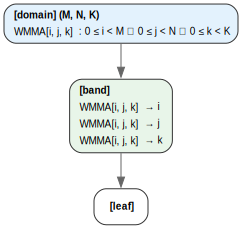

In [3]:
def create_gemm_schedule():
    A, B, C = map(I.expr, ("A", "B", "C"))
    zero = I.expr(0)

    with P.parameter("M, N, K"):
        with P.domain("{ WMMA[i,j,k] : 0<=i<M and 0<=j<N and 0<=k<K }") as gemm:
            with P.band("{ WMMA[i,j,k] -> [i, j, k] }"):
                P.stmt("C[j,i] = C[j,i], A[k,i], B[j,k]")[
                    lambda i, j, k: C[j, i].assign(C[j, i] + A[k, i] * B[j, k])
                ]
    return gemm

print(create_gemm_schedule())
create_gemm_schedule().viz()